# Univariate Forecasting with sktime

For BENV0119: In order to use `sktime`, you'll need to install it and its dependencies using:

```
conda activate benv0119
conda install -c conda-forge sktime-all-extras pmdarima
pip intstall tbats
```

This notebook is taken from the examples given by the `sktime` developers. The original version of the notebook can be found [on their Github page here](https://github.com/alan-turing-institute/sktime/blob/master/examples/01_forecasting.ipynb) along with many more examples. If you are having trouble running this notebook locally, you can run the original notebook on [Binder](https://hub.gke2.mybinder.org/user/alan-turing-institute-sktime-eyyrk89m/notebooks/examples/01_forecasting.ipynb) without having to install or download anything!

I also recommend reading this article on how sktime and time series analysis in general works: https://towardsdatascience.com/sktime-a-unified-python-library-for-time-series-machine-learning-3c103c139a55 

----------------------------

In forecasting, we're interested in using past data to make temporal forward predictions. `sktime` provides common statistical forecasting algorithms and tools for building composite machine learning models.


<img src="https://github.com/MitchellAcoustics/sktime/raw/3ab1ecc20ab2e5d2a19f3df13f07fa88b7c8d652/examples/img/forecasting.png" width=750 />

`sktime` provides a common, `scikit-learn`-like interface to a variety of classical and ML-style forecasting algorithms, together with tools for building pipelines and composite machine learning models, including temporal tuning schemes, or reductions such as walk-forward application of `scikit-learn` regressors.


### package imports

In [1]:
import numpy as np
import pandas as pd

## Basic forecasting workflows

### Data container format

`sktime` uses `pandas` for representing time series:

 * `pd.Series` for univariate time series and sequences
 * `pd.DataFrame` for multivariate time series and sequences

The `Series.index` and `DataFrame.index` are used for representing the time series or sequence index. `sktime` supports pandas integer, period, and timestamp indices.

To start, we use the Box-Jenkins univariate airline data set, which shows the number of international airline passengers per month from 1949 - 1960. Values are in thousands.

In [3]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

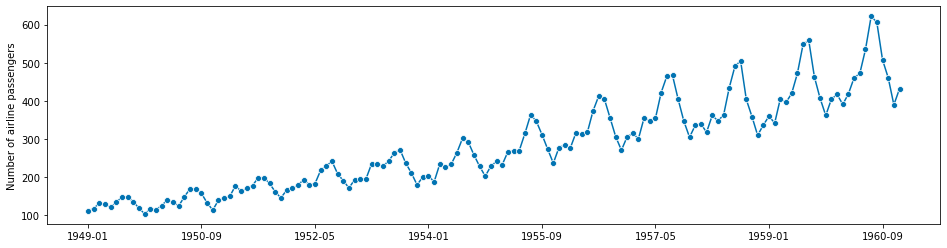

In [4]:
y = load_airline()
plot_series(y);  # note: sktime will expect pandas Series (not a full DataFrame) when doing univariate forecasting

A time series consists of a sequence of timepoint-value pairs, where the value represents the value we observed and the timepoint the point in time at which we observed that value.

We represent time series as a `pd.Series` where the index represents the timepoints. `sktime` supports pandas integer, period and timestamp indices. In this example, we have a period index:

In [5]:
y.index

PeriodIndex(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
             '1949-07', '1949-08', '1949-09', '1949-10',
             ...
             '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
             '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', length=144)

## Specifying the forecasting task

Next we will define a forecasting task.

* We will try to predict the last 3 years of data, using the previous years as training data. Each point in the series represents a month, so we should hold out the last 36 points as test data, and use 36-step ahead forecasting horizon to evaluate forecasting performance.
* We will use the MAPE (mean absolute percentage error) to quantify the accuracy of our forecasts. A lower MAPE means higher accuracy.

We can split the data as follows:

In [6]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon

108 36


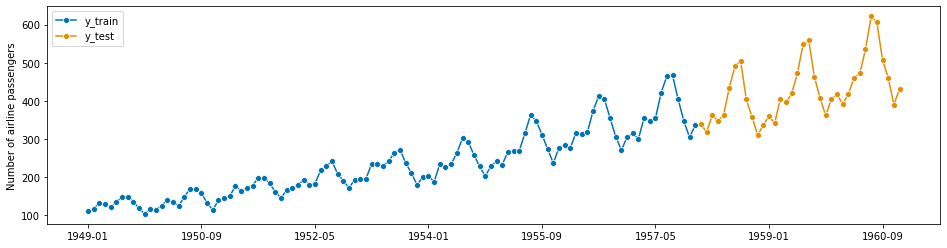

In [7]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

When we want to generate forecasts, we need to specify the forecasting horizon and pass that to our forecasting algorithm.

#### Relative forecasting horizon
One of the simplest ways is to define a `np.array` with the steps ahead that you want to predict relative to the end of the training series.

In [8]:
fh = np.arange(len(y_test)) + 1
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

So here we're interested in predicting from the first to to the 36th step ahead. Of course you could you use other forecasting horizons. For example, to predict only the second and fifth step ahead, you could write:

```python
import numpy as np
fh = np.array([2, 5])  # 2nd and 5th step ahead
```

#### Absolute forecasting horizon
Alternatively, we can specify the forecasting horizon using the absolute time points we want to predict. In order to do that, we need to use `sktime`'s `ForecastingHorizon` class. This way, we can simply create the forecasting horizon from the time points from the test set:

In [9]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['1958-01', '1958-02', '1958-03', '1958-04', '1958-05', '1958-06',
             '1958-07', '1958-08', '1958-09', '1958-10', '1958-11', '1958-12',
             '1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06',
             '1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12',
             '1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', is_relative=False)

## Generating forecasts

Like in scikit-learn, in order to make forecasts, we need to first specify (or build) a model, then fit it to the training data, and finally call predict to generate forecasts for the given forecasting horizon.

`sktime` comes with several forecasting algorithms (or forecasters) and tools for composite model building. All forecaster share a common interface. Forecasters are trained on a single series of data and make forecasts for the provided forecasting horizon.

### Naïve baselines
Let's start with two naïve forecasting strategies which can serve as references for comparison of more sophisticated approaches.

#### Predicting the last value

In [10]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

0.23195770387951434

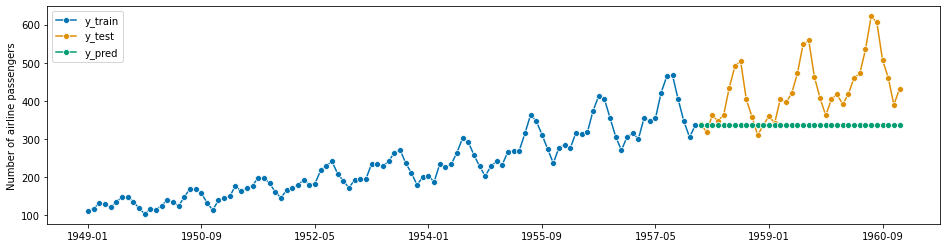

In [11]:
# using sktime
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

#### Predicting the last value of the same season

0.145427686270316

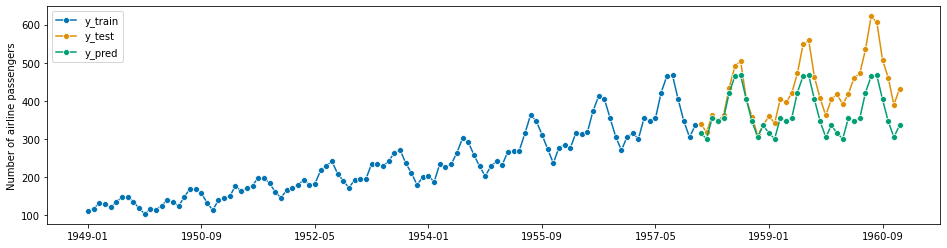

In [12]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

## Forecasters in `sktime` - main families

`sktime` has a number of commonly used forecasting algorithms, many of them interfaced from state-of-art forecasting packages. All forecasters are available under the unified `sktime` interface. 

The main classes that are currently stably supported are:

 * `ExponentialSmoothing`, `ThetaForecaster`, and `autoETS` from `statsmodels`.
 * `ARIMA` and `autoARIMA` from `pmdarima`
 * `BATS` and `TBATS` from `tbats`
 * `PolynomialTrend` for forecasting polynomial trends
 * `Prophet` which interfaces Facebook `prophet`

Generally, all forecasters available in `sktime` can be listed with the `all_estimators` command:

In [13]:
from sktime.registry import all_estimators
# all_estimators returns list of pairs - data frame conversion for pretty printing
all_estimators('forecaster', as_dataframe=True)

C:\Users\mitch\miniconda3\envs\BENV0119\lib\site-packages\sktime\registry\_lookup.py:156: ImportWarning: No module named 'esig'. 'esig' is a soft dependency and not included in the sktime installation. Please run: `pip install esig`. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(str(e), ImportWarning)
C:\Users\mitch\miniconda3\envs\BENV0119\lib\site-packages\sktime\registry\_lookup.py:156: ImportWarning: No module named 'fbprophet'. 'fbprophet' is a soft dependency and not included in the sktime installation. Please run: `pip install fbprophet`. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(str(e), ImportWarning)
C:\Users\mitch\miniconda3\envs\BENV0119\lib\site-packages\sktime\registry\_lookup.py:156: ImportWarning: No module named 'tbats'. 'tbats' is a soft dependency and not included in the sktime installation. Please run: `pip install tbats`. To install all soft dependencies, run: `pip install sktime

,name,estimator
0,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
1,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
2,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
3,AutoEnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.A...
4,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
5,Croston,<class 'sktime.forecasting.croston.Croston'>
6,DirRecTabularRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...
7,DirRecTimeSeriesRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...
8,DirectTabularRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...
9,DirectTimeSeriesRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...


All forecasters follow the same interface. We proceed by showcasing some commonly used classes of forecasters.

### Exponential smoothing, theta forecaster, autoETS from `statsmodels`

`sktime` interfaces a number of statistical forecasting algorithms from `statsmodels`: exponential smoothing, theta, and auto-ETS.

For example, to use exponential smoothing with an additive trend component and multiplicative seasonality on the airline data set, we can write the following:

Note that since this is monthly data, a good choice for seasonal periodicity is 12.

In [14]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

0.05144357774561398

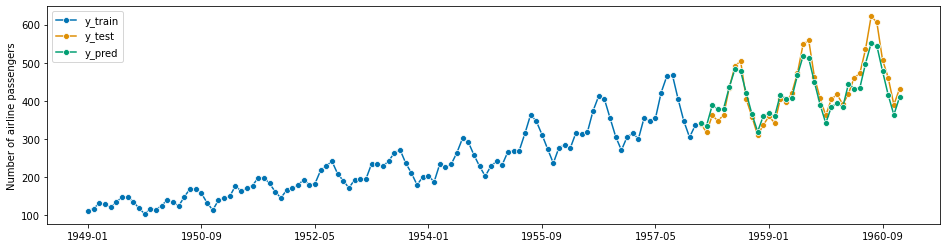

In [15]:
forecaster = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred)

The exponential smoothing of state space model can also be automated similar
 to the [ets](https://www.rdocumentation.org/packages/forecast/versions/8.13/topics/ets) function in R.

0.06317025583755462

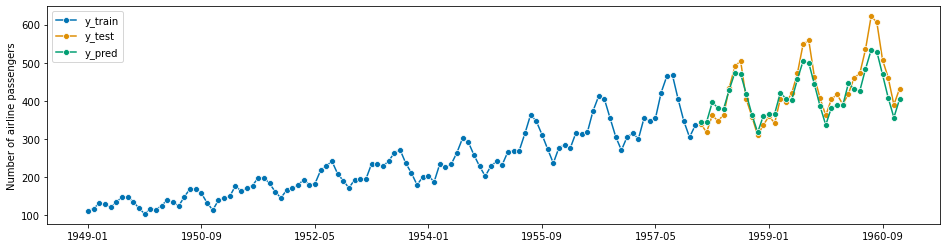

In [16]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred)

### ARIMA and autoARIMA

Another common model is the ARIMA model. `sktime` interfaces `pmdarima` for its ARIMA class models. For a classical ARIMA model with set parameters, use the `ARIMA` forecaster:

In [17]:
from sktime.forecasting.arima import ARIMA

0.06317025583755462

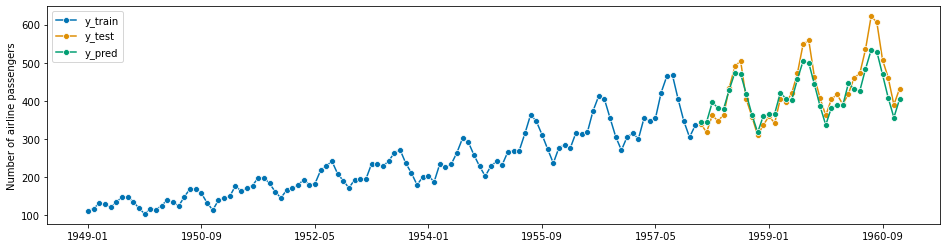

In [18]:
forcaster = ARIMA(
    order=(1,1,0), seasonal_order=(0,1,0,12), suppress_warnings=True
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

`AutoARIMA` is an automatically tuned `ARIMA` variant that obtains the optimal pdq parameters automatically:

In [19]:
from sktime.forecasting.arima import AutoARIMA

0.041170623702305884

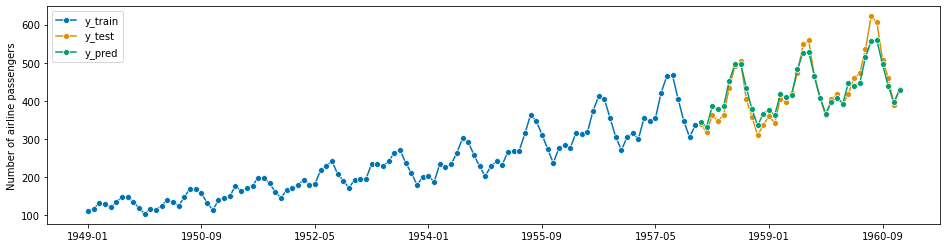

In [20]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred)

## 3 Advanced composition patterns - pipelines, reduction, autoML, and more

`sktime` supports a number of advanced composition patterns to create forecasters out of simpler components:

 * reduction - building a forecaster from estimators of 'simpler' scientific types, like `scikit-learn` regressors. A common example is feature/label tabulation by rolling window, aka the 'direct reduction strategy'.
 * tuning - determining values for hyper-parameters of a forecaster in a data-driven manner. A common example is grid search on temporally rolling resampling of train/test splits.
 * pipelining - concatenating transformers with a forecaster to obtain one forecaster. A common example is detrending and deseasonalizing then forecasting, an instance of this is the common 'STL forecaster'.
 * autoML, also know as automated model selection - using automated tuning strategies to select not only hyper-parameters but entire forecasting strategies. A common example is on-line multiplexer tuning. 


In [21]:
# imports necessary for this chapter
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

# data loading for illustration
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
fh = ForecastingHorizon(y_test.index, is_relative=False)

### 3.1 Reduction: from forecasting to regression

`sktime` provides a meta-estimator that allows the use of any `scikit-learn` estimator for forecasting.

 * **modular** and **compatible with scikit-learn**, so that we can easily apply any scikit-learn regressor to solve our forecasting problem.
 * **parametric** and **tunable**, allowing us to tune hyper-parameters such as the winndow length or strategy to generate forecasts.
 * **adaptive**, in the sense that it adapts the scikit-learn's estimator interface to that of a forecaster, making sure that we can tune and properly evaluate our model.

Example: we will define a tabulation reduction strategy to convert a k-nearest neighbors regressor (`sklearn` `KNeighborsRegressor`) into a forecaster. The composite algorithm is an object compliant with the `sktime` forecaster interface , and contains the regressor as a parameter accessible component. In `fit`, the composite algorithm uses a sliding window strategy to tabulate the data, and fit the regressor to the tabulated data. In `predict`, the composite algorithm presents the regressor with the last observed window to obtain predictions.

In [22]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

In [23]:
regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=15, strategy='recursive')

0.14187443909112035

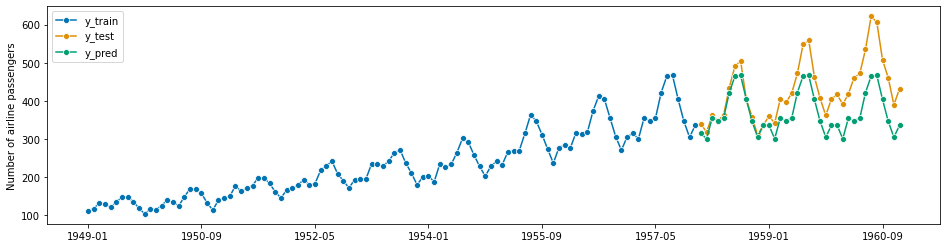

In [24]:
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
mean_absolute_percentage_error(y_pred, y_test)

Parameters can be inspected using `scikit-learn` compatible `get_params` functionality (and set using `set_params`). This provides tunable and nested access to parameters of the `KNeighborsRegressor` (as `estimator_etc`), and the `window_length` of the reduction strategy. Note that the `strategy` is not accessible, as underneath the utility function this is mapped on separate algorithm classes.

In [25]:
forecaster.get_params()

{'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 1,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'estimator': KNeighborsRegressor(n_neighbors=1),
 'window_length': 15}

### 3.2 Pipelining, detrending and deseasonalization

A common composition motif is pipelining: for example, first deseasonalizing or detrending the data, then forecasting the detrended/deseasonalized series. When forecasting, one needs to add the trend and seasonal component back to the data.

#### 3.2.1 The basic forecasting pipeline

`sktime` provides a generic pipeline object for this kind of composite modelling, the `TransformedTargetForecaster`. It chains an arbitrary number of transformations with a forecaster. The transformations should be instances of estimators with series-to-series-transformer scitype. An example of the syntax is below:

In [26]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer

0.15497688051238762

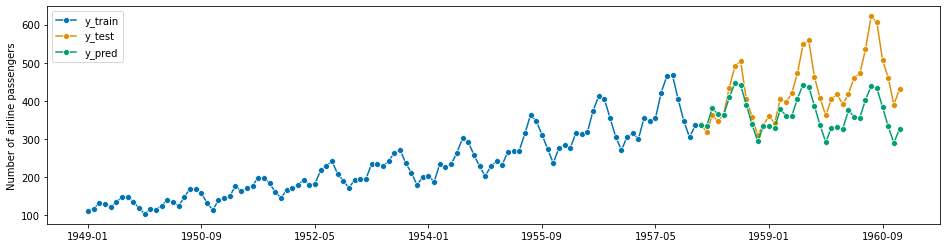

In [27]:
forecaster = TransformedTargetForecaster(
    [
        ('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
        ('forecast', ARIMA()),
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
mean_absolute_percentage_error(y_pred, y_test)

The `TransformedTargetForecaster` is constructed with a list of steps, each a pair of name and estimator. The last estimator should be of forecaster scitype, the other estimators should be series-to-series transformers which possess both a `transform` and `inverse_transform` method. The resulting estimator is of forecaster scitype and has all interface defining methods. In `fit`, all transformers apply `fit_transforms` to the data, then the forecaster's `fit`; in `predict`, first the forecaster's `predict` is applied, then the transformers' `inverse_transform` in reverse order.

#### 3.2.2 The `Detrender` as pipeline component

For detrending, we can use the `Detrender`. This is an estimator of series-to-transformer scitype that wraps an arbitrary forecaster. For example, for linear detrending, we can use `PolynomialTrendForecaster` to fit a linear trend, and then subtract/add it using the `Detrender` transformer inside `TransformedTargetForecaster`.

To understand better what happens, we first examine the detrender separately:

In [28]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

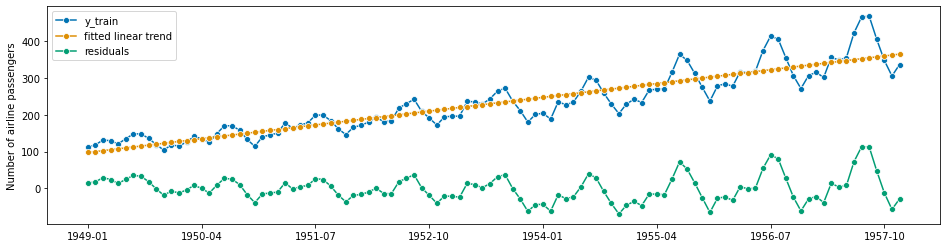

In [29]:
# linear detrending

forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(y_train)

# internally, the Detrender uses the in-sample predictions of the PolynomialTrendForecaster
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(y_train)) # in-sample forecasting horizon
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)

plot_series(y_train, y_pred, yt, labels=['y_train', 'fitted linear trend', 'residuals'])

Since the `Detrender` is of scitype series-to-series-transformer, it can be used in the `TransformedTargetForecaster` for detrending any forecaster:

0.05755295634736948

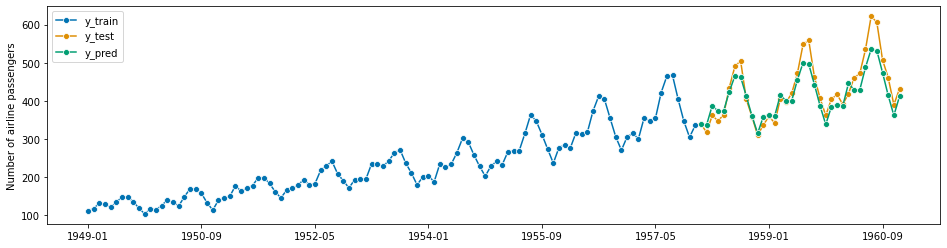

In [30]:
forecaster = TransformedTargetForecaster(
    [
        ('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
        ('detrend', Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ('forecast', ARIMA())
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
mean_absolute_percentage_error(y_pred, y_test)

### 3.3 Parameter Tuning

`sktime` provides parameter tuning strategies as compositors of forecaster scitype, similar to `scikit-learn`'s `GridSearchCV`.

#### 3.3.1 Basic tuning using `ForecastingGridSearchCV`

The compositor `ForecastingGridSearchCV` (and other tuners) are constructed with a forecaster to tune, a cross-validation constructor, a `scikit-learn` parameter grid, and parameters specific to the tuning strategy. Cross-validation constructors follow the `scikit-learn` interface for re-samples, and can be slotted in exchangeably.

As an example, we show tuning of the window length in the reduction compositor from Section 3.1, using temporal sliding window tuning:

In [31]:
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter

In [32]:
regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, window_length=15, strategy='recursive')
param_grid = {'window_length': [7, 12, 15]}

# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper-parameters
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(
    forecaster, strategy='refit', cv=cv, param_grid=param_grid
)

As with other composites, the resulting forecaster provides the unified interface of `sktime` forecasters - window splitting, tuning, etc requires no manual effort and is done behind the unified interface.

0.18870411034040024

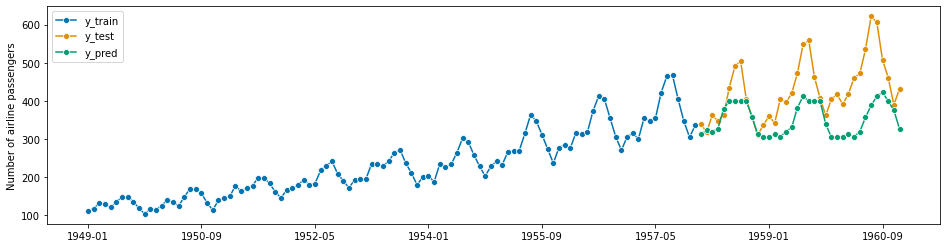

In [33]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
mean_absolute_percentage_error(y_pred, y_test)

Tuned parameters can be accessed in the `best_params_` attribute:

In [34]:
gscv.best_params_

{'window_length': 7}

An instance of the best forecaster, with hyper-parameters set, can be retrieved by accessing the `best_forecaster_` attribute:

In [35]:
gscv.best_forecaster_

RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                     window_length=7)

Using scikit-learn's `GridSearchCV`, we can tune regressors imported from scikit-learn, in addition to tuning `window_length`.

#### 3.2.2 Tuning of complex composites

As in `scikit-learn`, parameters of nested components can be tuned by accessing their `get_params` key - by default this is `[estimatorname]__[parametername]` if `[estimatorname]` is the name of the component, and `[parametername`] the name of a parameter within the estimator `[estimatorname]`.

For example, below we tune the `KNeighborsRegressor` component's `n_neighbors`, in addition to tuning `window_length`. the tuneable parameters can easily be queried using `forecaster.get_params()`.

In [36]:
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter

In [37]:
param_grid = {'window_length': [7, 12, 15], 'estimator__n_neighbors': np.arange(1, 10)}

regressor = KNeighborsRegressor()
forecaster = make_reduction(
    regressor, scitype='tabular-regressor', strategy='recursive'
)
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=30)
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)

0.1539546827317818

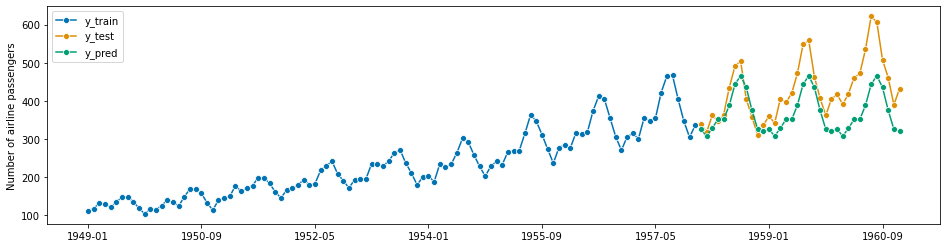

In [38]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In [39]:
gscv.best_params_

{'estimator__n_neighbors': 2, 'window_length': 12}

In [40]:
gscv.cv_results_

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.117011,0.002319,0.002504,"{'estimator__n_neighbors': 1, 'window_length': 7}",24.0
1,0.093021,0.002756,0.002910,"{'estimator__n_neighbors': 1, 'window_length':...",10.0
2,0.092872,0.003229,0.003180,"{'estimator__n_neighbors': 1, 'window_length':...",9.0
3,0.101923,0.002363,0.002912,"{'estimator__n_neighbors': 2, 'window_length': 7}",17.0
4,0.072555,0.002956,0.002909,"{'estimator__n_neighbors': 2, 'window_length':...",1.0
5,0.073753,0.002594,0.002636,"{'estimator__n_neighbors': 2, 'window_length':...",2.0
6,0.114049,0.002723,0.003049,"{'estimator__n_neighbors': 3, 'window_length': 7}",22.0
7,0.084299,0.003089,0.002817,"{'estimator__n_neighbors': 3, 'window_length':...",3.0
8,0.092868,0.002908,0.003682,"{'estimator__n_neighbors': 3, 'window_length':...",8.0
9,0.091437,0.003047,0.003137,"{'estimator__n_neighbors': 4, 'window_length': 7}",7.0


## Prediction intervals
So far, we've only looked at point forecasts. In many cases, we're also interested in prediction intervals. `sktime`'s interface support prediction intervals, but we haven't implemented them for all algorithms yet.


In [41]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)
mean_absolute_percentage_error(y_test, y_pred)

0.041170623702305884

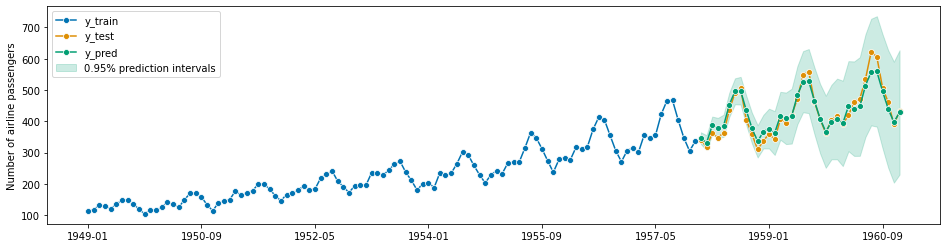

In [42]:
fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

We can compare this to another method, the theta forecasting algorithm

In [43]:
forecaster = TransformedTargetForecaster(
    [
        ('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
        ('detrend', Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ('forecast', AutoARIMA())
    ]
)
forecaster.fit(y_train)
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)
mean_absolute_percentage_error(y_test, y_pred)

0.05878219160787108

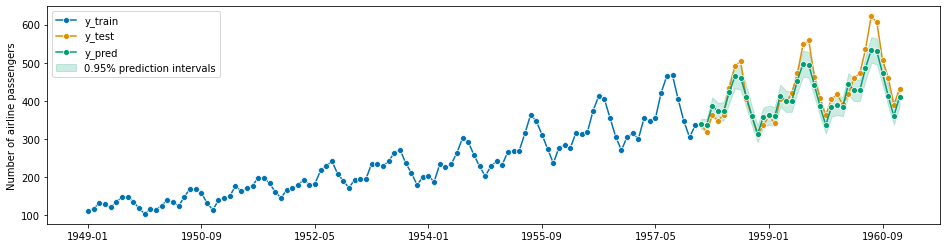

In [44]:
fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

## Summary

As we have seen, in order to make forecasts, we need to first specify (or build) a model, then fit it to the training data, and finally call predict to generate forecasts for the given forecasting horizon.

* `sktime` comes with several forecasting algorithms (or forecasters) and tools for composite model building. All forecaster share a common interface. Forecasters are trained on a single series of data and make forecasts for the provided forecasting horizon.

* `sktime` has a number of statistical forecasting algorithms, based on implementations in statsmodels. For example, to use exponential smoothing with an additive trend component and multiplicative seasonality, we can write the following.


## Useful resources
* For more details, take a look at [our paper on forecasting with sktime](https://arxiv.org/abs/2005.08067) in which we discuss the forecasting API in more detail and use it to replicate and extend the M4 study.
* For a good introduction to forecasting, see [Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice. OTexts, 2018](https://otexts.com/fpp2/).
* For comparative benchmarking studies/forecasting competitions, see the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) and the currently running [M5 competition](https://www.kaggle.com/c/m5-forecasting-accuracy/overview).